# 使用 Logistic Regression 作為 Basline ，且改預測使用者的屬性
* 因為預測消費金額，目前資料解釋力尚不足，故原的 Y 值定義在此 Notebook 中會被修改
* 改為預測使用者屬性作為 Baseline 來驗證這些 feature 是否具有足夠的代表力
* 且避免使用過度複雜模型


In [ ]:
# 如果有使用 coloab 再執行此 cell
from google.colab import drive
drive.mount('/gdrive')
!ln -s /gdrive/MyDrive/colab/NCKU_embedding/data/ ./data

Mounted at /gdrive


In [ ]:
import os
import numpy as np
import pandas as pd
from time import time
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

## Do One Hot Encode
* User this function [pd.get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)
* just for category column 

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def to_one_hot(df, sparse_feature, dense_feat, one_hot_encoder):
    df[sparse_feature] = df[sparse_feature].astype(object)

#     temp_col = list(set(df.columns)-set(sparse_feature))
#     temp_col.sort(key=list(df.columns).index)
    
    
    temp_matrix = one_hot_encoder.transform(df[sparse_feature])
    temp_pd = pd.DataFrame.sparse.from_spmatrix(temp_matrix, index=None, columns=one_hot_encoder.get_feature_names(sparse_feature))
    
    df = pd.concat([df[dense_feat], temp_pd] , axis=1)

    return df

In [ ]:
sample_path = './data/sample_50k'
shift = 0
x_train = pd.read_csv(os.path.join(sample_path, 'Normal_%d'%shift, 'x_train.csv'), encoding='utf-8')
x_test = pd.read_csv(os.path.join(sample_path, 'Normal_%d'%shift, 'x_test.csv'), encoding='utf-8')
y_train = pd.read_csv(os.path.join(sample_path, 'Normal_%d'%shift, 'y_train.csv'), encoding='utf-8').values
y_test = pd.read_csv(os.path.join(sample_path, 'Normal_%d'%shift, 'y_test.csv'), encoding='utf-8').values

chid_mapper = np.load(os.path.join(sample_path, 'sample_idx_map.npy'), allow_pickle=True).item()
feat_mapper = np.load(os.path.join(sample_path, 'Normal_%d'%shift, 'feature_map.npy'), allow_pickle=True).item()
feature = np.load(os.path.join(sample_path, 'Normal_%d'%shift, 'feature.npy'), allow_pickle=True).item()

category_cols = feature['category_columns']
numeric_cols = feature['numeric_columns']

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, len(chid_mapper), [(k, len(v)) for k, v in feat_mapper.items()])

(450000, 31) (100000, 31) (450000, 1) (100000, 1) 50000 [('masts', 4), ('educd', 7), ('naty', 3), ('trdtp', 28), ('poscd', 10), ('cuorg', 29)]


In [ ]:
user_list_train = x_train['chid']
user_list_test = x_test['chid']

In [ ]:
x_train = x_train.drop(['chid'], axis=1)
x_test = x_test.drop(['chid'], axis=1)

In [ ]:
x_train

,masts,educd,naty,trdtp,poscd,cuorg,monin,wrky,first_mob,cycam,slam,sum_area_c,sum_u2_ind,sum_u3_ind,sum_u4_ind,sum_l2_ind,sum_l3_ind,sum_l4_ind,constant_area_c,constant_u2_ind,constant_u3_ind,constant_u4_ind,constant_l2_ind,constant_l3_ind,constant_l4_ind,constant_change,growth_rate,monotone_up,monotone_down,objam
0,1,5,2,10,1,8,982800.0,0.0,197.0,5200000.0,5200000.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.5,2.0,0.0,243631.0
1,1,5,2,10,1,8,982800.0,0.0,198.0,5200000.0,5200000.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.0,1.0,4160.0
2,1,5,2,10,1,8,982800.0,0.0,199.0,5200000.0,5200000.0,0.0,1.0,1.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.0,4.0,941091.0
3,1,5,2,10,1,8,982800.0,0.0,200.0,5200000.0,6136000.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.0,1.0,101723.0
4,1,5,2,10,1,8,982800.0,0.0,201.0,5200000.0,5200000.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.9,0.0,1.0,631811.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449995,3,5,2,3,4,8,335785.0,11.0,79.0,260000.0,338000.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.3,1.0,0.0,79945.0
449996,3,5,2,3,4,8,335785.0,11.0,80.0,260000.0,338000.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,34471.0
449997,3,5,2,3,4,8,335785.0,11.0,81.0,260000.0,338000.0,2.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.2,1.0,0.0,59160.0
449998,3,5,2,3,4,8,427456.0,11.0,82.0,1300000.0,1300000.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,19038.0


### 選取所需要的 column 
<span style="color:red">（！！記得修改預設的 Y Colunm）</span>
* 去掉 chid
* 

In [ ]:
nwe_y_col = 'trdtp'

new_y = x_train[nwe_y_col]
new_y.unique()

array([10, 7, 25, 5, 9, 23, 3, 17, 18, 16, 8, 27, 13, 4, 2, 26, 15, 11, 6,
       12, 20, 24, 22, 19, 21, 1, 14], dtype=object)

In [ ]:
sparse_feat = category_cols[1:]
dense_feat = numeric_cols


In [ ]:
one_hot_encoder = OneHotEncoder()
# one_hot_encoder.get_feature_names()
one_hot_encoder.fit(x_train[sparse_feat])
one_hot_encoder.fit(x_test[sparse_feat])

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [ ]:
# USE_CHID = False
# idx_start = 1-int(USE_CHID)

x_train_oh = to_one_hot(x_train, sparse_feat, dense_feat, one_hot_encoder)
x_test_oh  = to_one_hot(x_test , sparse_feat, dense_feat, one_hot_encoder)

print(x_train_oh.shape)
print(x_test_oh.shape)

(450000, 100)
(100000, 100)


In [ ]:
x_train_oh.head(2)

,monin,wrky,first_mob,cycam,slam,sum_area_c,sum_u2_ind,sum_u3_ind,sum_u4_ind,sum_l2_ind,sum_l3_ind,sum_l4_ind,constant_area_c,constant_u2_ind,constant_u3_ind,constant_u4_ind,constant_l2_ind,constant_l3_ind,constant_l4_ind,constant_change,growth_rate,monotone_up,monotone_down,objam,masts_0,masts_1,masts_2,masts_3,educd_0,educd_1,educd_2,educd_3,educd_4,educd_5,educd_6,naty_0,naty_1,naty_2,trdtp_0,trdtp_1,...,poscd_0,poscd_1,poscd_2,poscd_3,poscd_4,poscd_5,poscd_6,poscd_7,poscd_8,poscd_9,cuorg_0,cuorg_1,cuorg_2,cuorg_3,cuorg_4,cuorg_5,cuorg_6,cuorg_7,cuorg_8,cuorg_9,cuorg_10,cuorg_11,cuorg_12,cuorg_13,cuorg_14,cuorg_15,cuorg_16,cuorg_17,cuorg_18,cuorg_19,cuorg_20,cuorg_21,cuorg_22,cuorg_23,cuorg_24,cuorg_25,cuorg_26,cuorg_27,cuorg_28,cuorg_29
0,119803.0,52.0,82.0,156000.0,202800.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,17899.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,119803.0,52.0,83.0,156000.0,202800.0,0.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.9,0.0,1.0,33520.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
x_train_oh.shape

(450000, 106)

## Do normalization for X data

In [ ]:
# x_data
x_scaler = MinMaxScaler(feature_range=(0, 1))

x_train_oh[dense_feat] = np.log1p(x_train_oh[dense_feat] - x_train_oh[dense_feat].min(axis=0))
x_train_oh[dense_feat] = x_scaler.fit_transform(x_train_oh[dense_feat])

x_test_oh[dense_feat] = np.log1p(x_test_oh[dense_feat] - x_test_oh[dense_feat].min(axis=0))
x_test_oh[dense_feat] = x_scaler.transform(x_test_oh[dense_feat])

x_train_oh = x_train_oh.values
x_test_oh = x_test_oh.values

In [ ]:
x_train_oh.shape

(450000, 106)

## Do normalization for Y data and do log transformation

In [ ]:
# y_data
USE_YMINMAX = True
y_scaler = None

y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

if USE_YMINMAX:
    y_scaler = MinMaxScaler(feature_range=(0, 1))
    y_train = y_scaler.fit_transform(y_train)
    y_test = y_scaler.transform(y_test)

In [ ]:
print(x_train_oh.shape, y_train.shape)
print(x_test_oh.shape, y_test.shape)

(450000, 106) (450000, 1)
(100000, 106) (100000, 1)


In [ ]:
# Lasso(alpha=1.0, *, fit_intercept=True, normalize=False, precompute=False, copy_X=True, max_iter=1000, tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')

In [ ]:
TRAIN_TYPE = [('L1loss', 'epsilon_insensitive'), 
              ('L2loss', 'squared_epsilon_insensitive')]
loss_type, loss = TRAIN_TYPE[0]

t0 = time()
# svr = LinearRegression()
svr = Lasso(alpha=.01)
svr.fit(x_train_oh, y_train.ravel())
t1 = time()

print('cost: {:.2f}'.format(t1 - t0))

cost: 0.68


In [ ]:
train_pred_list = svr.predict(x_train_oh)
train_pred_list = y_scaler.inverse_transform(train_pred_list.reshape([-1,1]))
train_pred_list = np.expm1(train_pred_list)


In [ ]:
train_true_list = y_scaler.inverse_transform(y_train) 
train_true_list = np.expm1(train_true_list)


In [ ]:


train_result = {
    'RMSE': mean_squared_error(train_true_list, train_pred_list, squared=False), 
    'MAE(mean)': mean_absolute_error(train_true_list, train_pred_list), 
    'MAE(median)': median_absolute_error(train_true_list, train_pred_list)
}
train_result

{'MAE(mean)': 61654.71583501958,
 'MAE(median)': 10829.935583003451,
 'RMSE': 347791.3594774047}

In [ ]:
test_true_list = y_test.ravel()
test_pred_list = svr.predict(x_test_oh)

if y_scaler:
    test_true_list = y_scaler.inverse_transform(test_true_list.reshape([-1,1]))
    test_pred_list = y_scaler.inverse_transform(test_pred_list.reshape([-1,1]))
    
test_true_list = np.expm1(test_true_list)
test_pred_list = np.expm1(test_pred_list)

test_result = {
    'RMSE': mean_squared_error(test_true_list, test_pred_list, squared=False), 
    'MAE(mean)': mean_absolute_error(test_true_list, test_pred_list), 
    'MAE(median)': median_absolute_error(test_true_list, test_pred_list)
}

In [ ]:
test_result

{'MAE(mean)': 68495.66548110738,
 'MAE(median)': 11916.913641484756,
 'RMSE': 347554.2316815595}

### 測試結果
* 從 RMSE、MAE(mean) 與 MAE(median) 這麼大差距來看，有些 instance outliner 所造成的
* 需要再看一下 objam 的分佈
* 另外思考預測所有消費金額是否洽當


### 確認哪些 Featrue 是有作用的
* trdtp -> 行業別
* educd -> 教育

In [ ]:
from itertools import compress

list(compress(list(one_hot_encoder.get_feature_names(sparse_feat)),list(svr.coef_!=0)))


['educd_1', 'trdtp_9']

In [ ]:
print('train\t'+' '.join(['{}:{:.2f}'.format(k, v) for k, v in train_result.items()]))
print('test\t'+' '.join(['{}:{:.2f}'.format(k, v) for k, v in test_result.items()]))

train	RMSE:347791.36 MAE(mean):61654.72 MAE(median):10829.94
test	RMSE:347554.23 MAE(mean):68495.67 MAE(median):11916.91


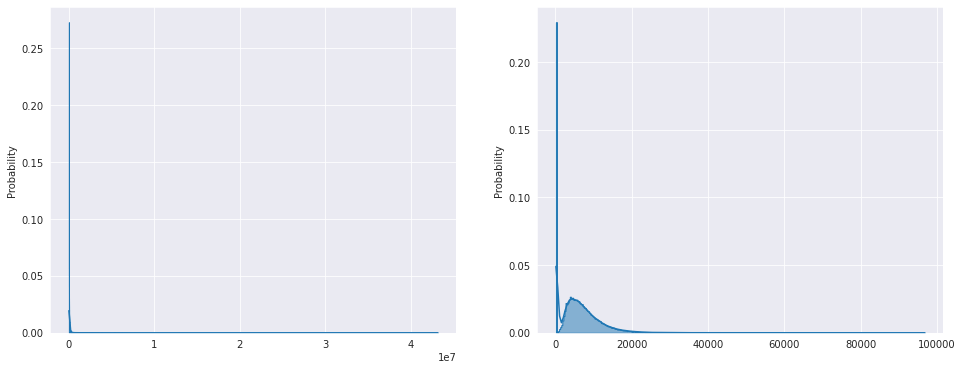

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6),)

    sns.histplot(ax=axes[0], x=test_true_list.reshape([-1,]), kde=True, element='step', stat='probability')
    sns.histplot(ax=axes[1], x=test_pred_list.reshape([-1,]), kde=True, element='step', stat='probability')

plt.show()

ValueError: ignored

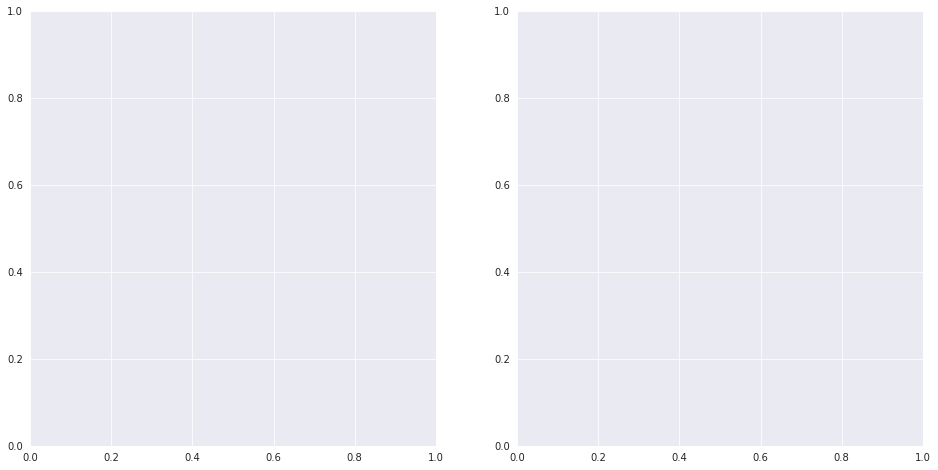

In [ ]:
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=False)
    fig.suptitle('')

    sns.scatterplot(ax=axes[0], x=test_true_list, y=test_pred_list)
    xylim = (np.min([test_true_list, test_pred_list])-.1e7, np.max([test_true_list, test_pred_list])+.1e7)
    axes[0].set(xlabel='True', ylabel='Pred', xlim=xylim, ylim=xylim)
    
    sns.scatterplot(ax=axes[1], x=test_true_list, y=test_true_list-test_pred_list)
    xylim = (np.min([test_true_list, test_true_list-test_pred_list])-.1e7, np.max([test_true_list, test_true_list-test_pred_list])+.1e7)
    axes[1].set(xlabel='True', ylabel='True - Pred', xlim=xylim, ylim=xylim)
    plt.show()

In [ ]:
df_out = pd.DataFrame({
    'chid': x_test.iloc[:, 0].values.astype(np.int64), 
    'true': test_true_list.flatten(),
    'pred': test_pred_list.flatten()
})

df_out.head(2)

In [ ]:
#df_out.to_csv('result/linearSVR.csv', index=False, encoding='utf-8')